# Importing the packages

The overall objective is to create a structured pipeline for downscaling the adm1.5 yield datasets (collected by Bunge at meso-region level) to adm2 level yield datasets (collected by IBGE at county level). This process is the first step for developing yield forecasts.

This step involves importing all the modules and packages that are essential for downscaling. It is equally important to import some modules from Bunge directory such as Utils, PAIRSSQL, AYP_Util, FileIO, PSQL, bowen's vault, feature selection, and model configuration.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.filterwarnings("ignore")
from sklearn import metrics
from matplotlib.ticker import MaxNLocator
from scipy import stats
from scipy.stats import kurtosis
from scipy.stats import skew
import statsmodels.api as sm
from statsmodels.tsa.filters.hp_filter import hpfilter
from bunge_utils import feature_selection as bfs

from bunge_utils import FileIO, PSQL
from bunge_utils import gcs

In [ ]:
brz_adm2 = gcs.GS().open_gc_geojsonfile("gs://bunge-access-point/input/geojsons/BRZ_adm2.geojson")
map_code = brz_adm2[['vector_id','meso_iso']]
map_code['state'] = map_code.meso_iso.str.split('.', expand=True)[1]
map_code.rename(columns={'vector_id':'muni_iso'}, inplace=True)
map_code.shape

(5572, 3)

# Adm2 (County level) AYP

## Importing the data

Admin 2 level datasets for Brazil is the County level dataset. IBGE is the data provider for county level weather parameters in Brazil (just like PRISM in US). This dataset source has no affiliation with Bunge. This dataset is not as accurate as the adm 1.5 level datasets which are provided by Bunge. The whole purpose of this activity is to rectify the adm2 level datasets.

In [ ]:
_ibge_adm2 = PSQL.get_soam_ayp_stats_allcrops(
    _reg='BR', _level='adm2', _source=2)

In [ ]:
_ibge_adm2.head(2)

,country,vector_id,level,year1,year2,crop_name,crop,source_name,source,acreage_planted,yield,yield_harvested,yield_planted,production,acreage_harvested,ts,planted_year,harvested_year
0,BR,1716604,adm2,1973,1974,Soy First Planted,1,IBGE,2,NaN,1.200,1.200000,NaN,120.0,100.0,2021-10-05 11:19:31,1973,1974
1,BR,2904902,adm2,1973,1974,Soy First Planted,1,IBGE,2,NaN,1.767,1.766667,NaN,53.0,30.0,2021-10-05 11:19:31,1973,1974


In [ ]:
_ibge_adm2.harvested_year.unique()

array([1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2020], dtype=object)

We are missing two years of yield datasets.

## Investigating the data structure

In [ ]:
_ibge_adm2['crop_name'].unique()

array(['Soy First Planted', 'Corn First Planted', 'Corn Second Planted',
       'Cotton First Planted'], dtype=object)

In [ ]:
_ibge_adm2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229932 entries, 0 to 229931
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   country            229932 non-null  object        
 1   vector_id          229932 non-null  object        
 2   level              229932 non-null  object        
 3   year1              229932 non-null  object        
 4   year2              229932 non-null  object        
 5   crop_name          229932 non-null  object        
 6   crop               229932 non-null  object        
 7   source_name        229932 non-null  object        
 8   source             229932 non-null  object        
 9   acreage_planted    195934 non-null  float64       
 10  yield              228159 non-null  float64       
 11  yield_harvested    227962 non-null  float64       
 12  yield_planted      194506 non-null  float64       
 13  production         228506 non-null  float64 

In [ ]:
_ibge_adm2['harvested_year'] = _ibge_adm2['harvested_year'].astype(int)
_ibge_adm2['vector_id'] = _ibge_adm2['vector_id'].astype(int)
_ibge_adm2['planted_year'] = _ibge_adm2['planted_year'].astype(int)
display(_ibge_adm2.shape)
_ibge_adm2.describe().transpose()

(229932, 18)

,count,mean,min,25%,50%,75%,max,std
vector_id,229932.0,3519126.664396,1100015.0,2900900.0,3528700.0,4209854.0,5300108.0,978728.212852
acreage_planted,195934.0,4962.862025,0.0,150.0,672.0,2941.5,635000.0,18697.807828
yield,228159.0,2.527491,0.0,1.02,2.1,3.339,27.0,1.985465
yield_harvested,227962.0,2.5297,0.001,1.027376,2.1,3.346939,27.0,1.984895
yield_planted,194506.0,2.734957,0.0,1.2,2.4,3.6,27.608156,2.055513
production,228506.0,14522.954631,0.0,174.0,1140.0,7526.75,3841570.0,62128.50352
acreage_harvested,228506.0,4794.928111,0.0,140.0,600.0,2800.0,630000.0,17799.163938
ts,229932,2021-10-05 11:49:29.778621440,2021-10-05 11:19:31,2021-10-05 11:19:31,2021-10-05 11:19:39,2021-10-05 12:22:09,2021-10-05 12:22:09,NaN
planted_year,229932.0,2003.110937,1973.0,1995.0,2006.0,2013.0,2020.0,12.623031
harvested_year,229932.0,2004.012947,1974.0,1996.0,2007.0,2014.0,2020.0,12.552591


## Sorting, Filtering, and Merging

Keeping the datasets for soybean crop only. Merging the dataframe _ibge_adm2_soy with map_code(introduced in the beginning) to accumulate the yield datasets with the meso-region IDs (meso_iso). This step involves classifying and organizing the datasets while merging dataframes.

In [ ]:
_ibge_adm2.crop_name.unique()

array(['Soy First Planted', 'Corn First Planted', 'Corn Second Planted',
       'Cotton First Planted'], dtype=object)

In [ ]:
_ibge_adm2_soy = _ibge_adm2.copy()
_ibge_adm2_soy = _ibge_adm2_soy[_ibge_adm2_soy['crop_name'] == 'Soy First Planted']

In [ ]:
map_code = map_code.astype({'muni_iso':int})
_ibge_adm2_soy = pd.merge(_ibge_adm2_soy, map_code, left_on = 'vector_id',
                                      right_on = 'muni_iso')

In [ ]:
_ibge_adm2_soy.shape

(70805, 21)

In [ ]:
_ibge_adm2_soy.year2.unique()

array([1974, 1978, 1979, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 1975, 1976,
       1977, 1980, 1981], dtype=object)

## Organizing

In [ ]:
_ibge_adm2_soy_BR = _ibge_adm2_soy.copy()
_ibge_adm2_soy_BR = _ibge_adm2_soy_BR[['harvested_year', 'state', 'meso_iso',
                                       'muni_iso','vector_id','acreage_harvested',
                                       'acreage_planted','production', 'yield']]
_ibge_adm2_soy_BR.rename(columns = {'harvested_year':'year',
                                    'acreage_harvested': 'acreage_harvested_adm2',
                                    'acreage_planted': 'acreage_planted_adm2',
                                    'production': 'production_adm2',
                                    'yield': 'yield_adm2'}, inplace = True)
_ibge_adm2_soy_BR.head()

,year,state,meso_iso,muni_iso,vector_id,acreage_harvested_adm2,acreage_planted_adm2,production_adm2,yield_adm2
0,1974,TO,BR.TO.01,1716604,1716604,100.0,NaN,120.0,1.200
1,1978,TO,BR.TO.01,1716604,1716604,48.0,NaN,52.0,1.083
2,1979,TO,BR.TO.01,1716604,1716604,125.0,NaN,188.0,1.504
3,1982,TO,BR.TO.01,1716604,1716604,498.0,NaN,647.0,1.299
4,1983,TO,BR.TO.01,1716604,1716604,345.0,NaN,414.0,1.200


In [ ]:
_ibge_adm2_soy_BR.meso_iso.unique()

array(['BR.TO.01', 'BR.BA.02', 'BR.MG.02', 'BR.MG.04', 'BR.MG.03',
       'BR.MG.01', 'BR.ES.01', 'BR.SP.02', 'BR.SP.01', 'BR.PR.01',
       'BR.PR.03', 'BR.PR.02', 'BR.SC.01', 'BR.RS.03', 'BR.RS.02',
       'BR.RS.01', 'BR.MS.04', 'BR.MS.01', 'BR.MS.03', 'BR.MS.05',
       'BR.MS.02', 'BR.MT.03', 'BR.GO.01', 'BR.GO.02', 'BR.DF.01',
       'BR.MT.02', 'BR.MT.05', 'BR.MT.01', 'BR.TO.02', 'BR.MA.02',
       'BR.PI.01', 'BR.MT.06', 'BR.BA.01', 'BR.MA.01', 'BR.MT.04',
       'BR.RO.01', 'BR.SE.01', 'BR.PA.02', 'BR.AL.01', 'BR.CE.01',
       'BR.RJ.01', 'BR.PE.01', 'BR.AM.01', 'BR.PA.01', 'BR.AC.01',
       'BR.RR.01', 'BR.AP.01', 'BR.PB.01'], dtype=object)

In [ ]:
pd.Index(_ibge_adm2_soy_BR.meso_iso.unique())[pd.Index(_ibge_adm2_soy_BR.meso_iso.unique()).str.contains('PA')]

Index(['BR.PA.02', 'BR.PA.01'], dtype='object')

We are missing an adm1_5 over here (BR.PA.03) [PARA]

# ADM15 (Meso-region level) AYP

## Importing

PAIRS is a server that IBM provides. PSQL is a database that Chuck maintains. All the datasets used for modeling are available on the PSQL platform. This whole dataset retrieved from PSQL is maintained by Bunge and is highly accurate. Crop Code '9' is used for soybean.

The adm 1.5 level dataset is provided by Bunge grids. The local research team (with Victor, Janaina, and Mario) maintains it and helps in updating it weekly.

In [ ]:
PSQL.get_soam_crop_codes()

,code,description
0,1,Soy First Planted
1,2,Corn First Planted
2,3,Wheat First Planted
3,4,Soy Second Planted
4,5,Corn Second Planted
5,6,Corn First+Second Planted
6,7,Cotton First Planted
7,8,Sunflower First Planted
8,9,Soy First+Second Planted
9,10,Sorghum First Planted


IMPORTANT NOTE: The function needs to be cleaned in the PSQL later on. In addition to the adm1_5 level datasets, data at adm0 and adm1 is being retrieved as well. However, there are three adm1s (BR.SC, BR.PI, and BR.RO) which represent the same dataset as adm1_5s (BR.SC.01, BR.PI.01, and BR.RO.01), it is because these adm1s contain only one meso-region and they can be represented with their respective adm1_5 ids. Other than these three, we can get rid of other adm1s and adm0.

In [ ]:
_bg_adm15 = PSQL.get_soam_ayp_stats(_reg = 'BR', _crop = 9, _level = ['adm1.5'],
                                   _source = 1, _debug = False, _test = True)
_bg_adm15.replace({'BR.SC':'BR.SC.01','BR.PI':'BR.PI.01','BR.RO':'BR.RO.01'}, inplace=True)

In [ ]:
_bg_adm15.vector_id.unique()

array(['BR', 'BR.BA', 'BR.BA.01', 'BR.BA.02', 'BR.GO+DF', 'BR.DF.01',
       'BR.GO.01', 'BR.GO.02', 'BR.MA', 'BR.MA.01', 'BR.MA.02', 'BR.MG',
       'BR.MG.01', 'BR.MG.02', 'BR.MG.03', 'BR.MG.04', 'BR.MS',
       'BR.MS.01', 'BR.MS.02', 'BR.MS.03', 'BR.MS.04', 'BR.MS.05',
       'BR.MT', 'BR.MT.01', 'BR.MT.02', 'BR.MT.03', 'BR.MT.04',
       'BR.MT.05', 'BR.MT.06', 'BR.PA', 'BR.PA.01', 'BR.PA.02',
       'BR.PA.03', 'BR.PI.01', 'BR.PR', 'BR.PR.01', 'BR.PR.02',
       'BR.PR.03', 'BR.RO.01', 'BR.RS', 'BR.RS.01', 'BR.RS.02',
       'BR.RS.03', 'BR.SC.01', 'BR.SP', 'BR.SP.01', 'BR.SP.02', 'BR.TO',
       'BR.TO.01', 'BR.TO.02', 'BR.CE', 'BR.OTHERS', 'BR.OTHERS.N',
       'BR.OTHERS.NE', 'BR.OTHERS.SE'], dtype=object)

## Sorting and Filtering

In [ ]:
_bg_adm15_soy = _bg_adm15.copy()
_bg_adm15_soy = _bg_adm15_soy[['harvested_year', 'vector_id','acreage_planted',
                                       'production', 'yield']]

: 

Renaming the columns before merging them.

In [ ]:
_bg_adm15_soy.rename(columns = {'harvested_year': 'year','vector_id': 'meso_iso',
                                'acreage_planted': 'acreage_planted_adm15',
                                'production': 'production_adm15', 'yield':
                                'yield_adm15'}, inplace = True)

In [ ]:
_bg_adm15_soy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 0 to 1264
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   1265 non-null   int64  
 1   meso_iso               1265 non-null   object 
 2   acreage_planted_adm15  1265 non-null   float64
 3   production_adm15       1265 non-null   float64
 4   yield_adm15            1265 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 49.5+ KB


The next step invovled removing the meso-regions with incomplete datasets. Three meso-regions were identified.
In order to remove the selective rows from a column ('meso_iso'), the column was set as an index.
The selected meso-regions were dropped and then reset_index function was used to bring everything back.

In [ ]:
state_list = [
    'BR.BA.02','BR.CE.01','BR.MG.03','BR.OTHERS.N','BR.OTHERS.NE','BR.OTHERS.SE', 'BR.SP',
    'BR.GO+DF','BR','BR.BA','BR.MA','BR.MG','BR.MS','BR.MT','BR.PA','BR.PR','BR.RS']
_bg_adm15_soy = _bg_adm15_soy[~_bg_adm15_soy['meso_iso'].isin(state_list)]
_bg_adm15_soy = _bg_adm15_soy[['year','meso_iso','acreage_planted_adm15',
                               'production_adm15','yield_adm15']]

In [ ]:
_bg_adm15_soy.meso_iso.nunique()

39

In [ ]:
_bg_adm15_soy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 897 entries, 2 to 1261
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   897 non-null    int64  
 1   meso_iso               897 non-null    object 
 2   acreage_planted_adm15  897 non-null    float64
 3   production_adm15       897 non-null    float64
 4   yield_adm15            897 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 42.0+ KB


In [ ]:
_bg_adm15_soy_BR = _bg_adm15_soy.groupby(['year'], as_index=False).sum()[[
      'year','production_adm15', 'acreage_planted_adm15']]

_bg_adm15_soy_BR['yield_adm15'] = (
    _bg_adm15_soy_BR['production_adm15']/_bg_adm15_soy_BR['acreage_planted_adm15'])

# Downscaling

The admin 1.5 level dataset is downscaled to admin 2.0 level during this process.

## Merging adm2 with adm1.5

The first step is merging IBGE admin2 level datasets with Bunge adm1.5 level datasets. model_config was updated very recently (10/20/22).

In [ ]:
_ds_adm2 = _ibge_adm2_soy_BR.merge(_bg_adm15_soy, on = ['year', 'meso_iso'])

In [ ]:
_ds_adm2.head(2)

,year,state,meso_iso,muni_iso,vector_id,acreage_harvested_adm2,acreage_planted_adm2,production_adm2,yield_adm2,acreage_planted_adm15,production_adm15,yield_adm15
0,2001,TO,BR.TO.01,1716604,1716604,1600.0,1600.0,3040.0,1.9,35.493,83.938,2.364917
1,2001,TO,BR.TO.01,1703701,1703701,1900.0,1900.0,3990.0,2.1,35.493,83.938,2.364917


In [ ]:
_ds_adm2.meso_iso.nunique()

35

In [ ]:
_ds_adm2.year.unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020])

In [ ]:
pd.Index(_ibge_adm2_soy_BR.meso_iso.unique())[pd.Index(_ibge_adm2_soy_BR.meso_iso.unique()).str.contains('PA')]

Index(['BR.PA.02', 'BR.PA.01'], dtype='object')

We are missing the meso-region ('BR.PA.03') and 2 years (2021 and 2022) over here.

## Meso-share determination

Determining the share of 'yield', 'production', and 'acreage_harvested' values during each year and for each MESO REGION.

The current dataframe (_ds_adm2) has some parameters that are required from the mesoregion level which are production_adm15, acreage_planted_adm15, and yield_adm15. The mesoregion level datasets provided by Bunge are more accurate than IBGE. The next steps involve comparing the IBGE reported yield at adm2 level (county) with the Bunge reported yield at adm1.5 level (meso-region). In order to achieve that, 'meso_share_acreage_harvested', 'meso_share_production', and 'meso_share_yield' columns will be used.

In [ ]:
_sum_ac = _ds_adm2.groupby(['year','meso_iso'], as_index = False).sum()[[
    'year','meso_iso','acreage_harvested_adm2','acreage_planted_adm2','production_adm2']]
_sum_ac.rename(columns = {
    'acreage_harvested_adm2':'sum_acreage_harvested_adm2',
    'acreage_planted_adm2': 'sum_acreage_planted_adm2','production_adm2': 'sum_production_adm2'},inplace = True)

In [ ]:
new_ds_adm2 = pd.merge(_ds_adm2, _sum_ac, on = ['year', 'meso_iso'])

Creating a column for the meso_share and determining the meso_shares for harvest, acreage, and yield.

In [ ]:
new_ds_adm2['meso_share_acreage_harvested'] = new_ds_adm2['acreage_harvested_adm2']/new_ds_adm2['sum_acreage_harvested_adm2']
new_ds_adm2['meso_share_acreage_planted'] = new_ds_adm2['acreage_planted_adm2']/new_ds_adm2['sum_acreage_planted_adm2']
new_ds_adm2['meso_share_production'] = new_ds_adm2['production_adm2']/new_ds_adm2['sum_production_adm2']

## Downscaling AYP

In [ ]:
updated_ds_adm2 = new_ds_adm2.copy()
updated_ds_adm2['downscaled_production'] = updated_ds_adm2['meso_share_production'] \
*updated_ds_adm2['production_adm15']

updated_ds_adm2['downscaled_acreage_planted'] = updated_ds_adm2['meso_share_acreage_planted'] \
*updated_ds_adm2['acreage_planted_adm15']

updated_ds_adm2['downscaled_acreage_harvested'] = updated_ds_adm2['meso_share_acreage_harvested'] \
*updated_ds_adm2['acreage_planted_adm15']

updated_ds_adm2['downscaled_yield'] = \
updated_ds_adm2['downscaled_production']/updated_ds_adm2['downscaled_acreage_harvested']

# updated_ds_adm2[updated_ds_adm2['meso_iso'] == 'BR.MS.02'].tail()

In [ ]:
updated_ds_adm2.head(2)

,year,state,meso_iso,muni_iso,vector_id,acreage_harvested_adm2,acreage_planted_adm2,production_adm2,yield_adm2,acreage_planted_adm15,...,sum_acreage_harvested_adm2,sum_acreage_planted_adm2,sum_production_adm2,meso_share_acreage_harvested,meso_share_acreage_planted,meso_share_production,downscaled_production,downscaled_acreage_planted,downscaled_acreage_harvested,downscaled_yield
0,2001,TO,BR.TO.01,1716604,1716604,1600.0,1600.0,3040.0,1.9,35.493,...,35493.0,35493.0,83938.0,0.045079,0.045079,0.036217,3.04,1.6,1.6,1.9
1,2001,TO,BR.TO.01,1703701,1703701,1900.0,1900.0,3990.0,2.1,35.493,...,35493.0,35493.0,83938.0,0.053532,0.053532,0.047535,3.99,1.9,1.9,2.1


In [ ]:
updated_ds_adm2.meso_iso.nunique()

35

## Investigating for consistency

In [ ]:
sum_ds_adm2 = updated_ds_adm2.groupby(['meso_iso', 'year'],as_index=False)[[
    'downscaled_production', 'downscaled_acreage_harvested',
    'production_adm2','acreage_harvested_adm2']].sum()

sum_ds_adm2['downscaled_yield'] = (
    sum_ds_adm2['downscaled_production']/sum_ds_adm2['downscaled_acreage_harvested'])

sum_ds_adm2['IBGE_adm2_yield'] = (
    sum_ds_adm2['production_adm2']/sum_ds_adm2['acreage_harvested_adm2'])

sum_ds_adm2 = pd.merge(sum_ds_adm2,_bg_adm15_soy,  on = ['year','meso_iso'])

sum_ds_adm2 = sum_ds_adm2.reindex(columns = ('meso_iso','year','downscaled_acreage_harvested',
                                             'downscaled_production', 'production_adm2',
                                             'acreage_harvested_adm2', 'acreage_planted_adm15',
                                             'production_adm15', 'downscaled_yield',
                                             'yield_adm15', 'IBGE_adm2_yield'))
# sum_ds_adm2.tail()

In [ ]:
sum_ds_adm2.head(2)

,meso_iso,year,downscaled_acreage_harvested,downscaled_production,production_adm2,acreage_harvested_adm2,acreage_planted_adm15,production_adm15,downscaled_yield,yield_adm15,IBGE_adm2_yield
0,BR.BA.01,2001,690.0,1407.6,1407600.0,690000.0,690.0,1407.6,2.04,2.04,2.04
1,BR.BA.01,2002,800.0,1464.0,1464000.0,800000.0,800.0,1464.0,1.83,1.83,1.83


In [ ]:
sum_ds_adm2['meso_iso'].nunique()

: 

## Graphing yields

Keeping only the columns from the _ds_adm2 which are required, i.e.,adm1.5 adjusted yield and true adm2 yield.

In [ ]:
sum_ds_adm2_1 = sum_ds_adm2.groupby('year', as_index=False).sum()[[
    'year','downscaled_acreage_harvested','downscaled_production',
    'production_adm2','acreage_harvested_adm2']]

sum_ds_adm2_1 ['downscaled_yield'] = (
    sum_ds_adm2_1['downscaled_production']/sum_ds_adm2_1['downscaled_acreage_harvested'])

sum_ds_adm2_1['IBGE_adm2_yield'] = (
    sum_ds_adm2_1['production_adm2']/sum_ds_adm2_1['acreage_harvested_adm2'])

sum_ds_adm2_1 = pd.merge(sum_ds_adm2_1,_bg_adm15_soy_BR,  on = ['year'])

sum_ds_adm2_1 = sum_ds_adm2_1.reindex(columns = ('year','IBGE_adm2_yield',
                                                 'yield_adm15','downscaled_yield'))

: 

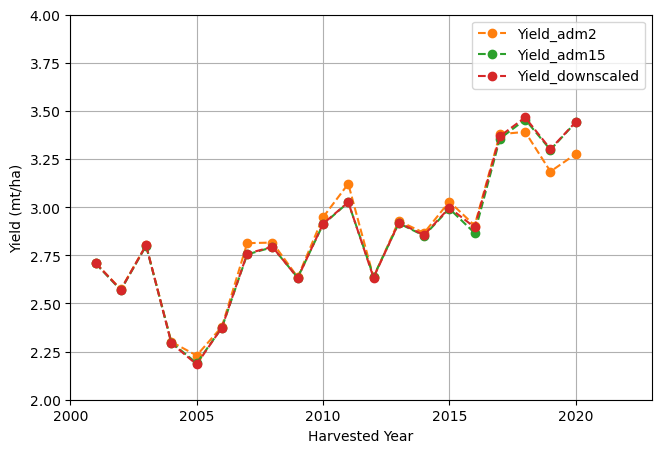

In [ ]:
fig, ax = plt.subplots(figsize = (7.5, 5))
plt.plot('year', 'IBGE_adm2_yield', data = sum_ds_adm2_1, marker = 'o', linestyle = '--', label = 'Yield_adm2', color = 'C1')
plt.plot('year', 'yield_adm15', data = sum_ds_adm2_1, marker = 'o', linestyle = '--', label = 'Yield_adm15', color = 'C2')
plt.plot('year', 'downscaled_yield', data = sum_ds_adm2_1, marker = 'o', linestyle = '--', label = 'Yield_downscaled',
         color = 'C3')
ax.set(xlim = [2000, 2023], ylim = [2,4], xlabel = 'Harvested Year', ylabel = 'Yield (mt/ha)')
ax.grid()
plt.legend()
plt.show()

In [ ]:
sum_ds_adm2_2 = sum_ds_adm2[sum_ds_adm2['meso_iso'] == 'BR.GO.02']
sum_ds_adm2_3 = sum_ds_adm2_2.groupby(['year'], as_index=False)[[
    'downscaled_yield','yield_adm15','IBGE_adm2_yield']].sum()

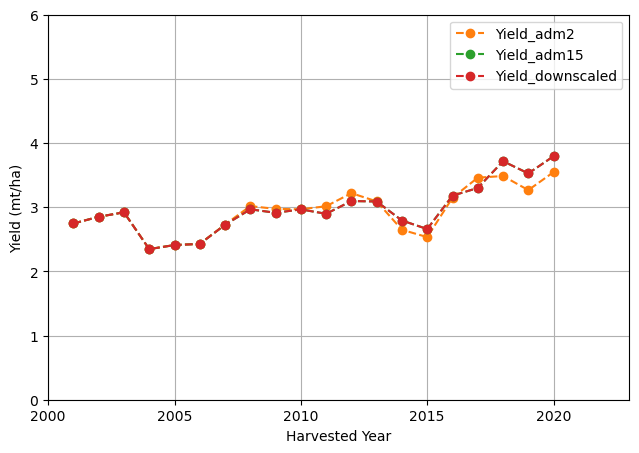

In [ ]:
fig, ax = plt.subplots(figsize = (7.5, 5))
plt.plot('year', 'IBGE_adm2_yield', data = sum_ds_adm2_3, marker = 'o', linestyle = '--', label = 'Yield_adm2', color = 'C1')
plt.plot('year', 'yield_adm15', data = sum_ds_adm2_3, marker = 'o', linestyle = '--', label = 'Yield_adm15', color = 'C2')
plt.plot('year', 'downscaled_yield', data = sum_ds_adm2_3, marker = 'o', linestyle = '--', label = 'Yield_downscaled',
         color = 'C3')
ax.set(xlim = [2000, 2023], ylim = [0, 6], xlabel = 'Harvested Year', ylabel = 'Yield (mt/ha)')
ax.grid()
plt.legend()
plt.show()

# HP Trend

This procedure begins with creating a copy of the last updated dataframe and then performing operations.

In [ ]:
df_dwnscl = updated_ds_adm2.copy()
df_dwnscl = df_dwnscl.reindex(columns = ('year','meso_iso', 'muni_iso','downscaled_production',
                                         'downscaled_acreage_harvested', 'downscaled_yield'))

## Data Visualization

Visualization is the most effective method to demonstrate the distribution of sample, along with accessing and understanding the sample size.

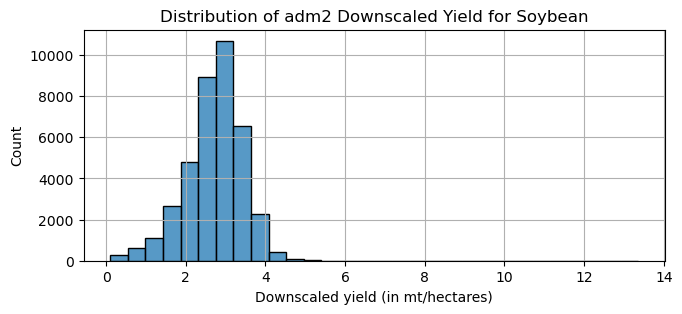

In [ ]:
fig, ax = plt.subplots(figsize = (7.5, 3))
ax.grid()
ax.set(title = 'Distribution of adm2 Downscaled Yield for Soybean',
       xlabel = 'Downscaled yield (in mt/hectares)', ylabel = 'Count')
sns.histplot(data = df_dwnscl, x = 'downscaled_yield' , bins = 30)
plt.show()

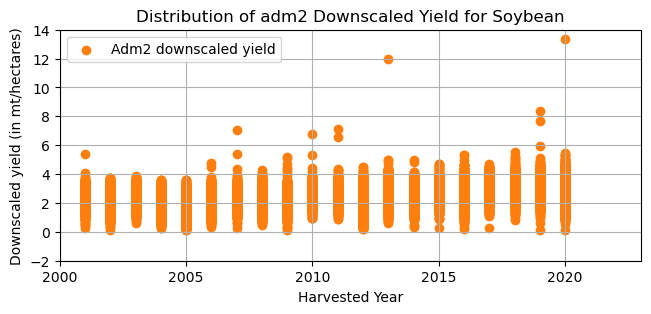

In [ ]:
fig, ax = plt.subplots(figsize = (7.5, 3))
plt.scatter('year', 'downscaled_yield', data = df_dwnscl, marker = 'o'
         , label = 'Adm2 downscaled yield', color = 'C1')

ax.set(xlim = [2000, 2023], ylim = [-2,14], xlabel = 'Harvested Year',
       ylabel = 'Downscaled yield (in mt/hectares)',
       title = 'Distribution of adm2 Downscaled Yield for Soybean')
ax.grid()
plt.legend()
plt.show()

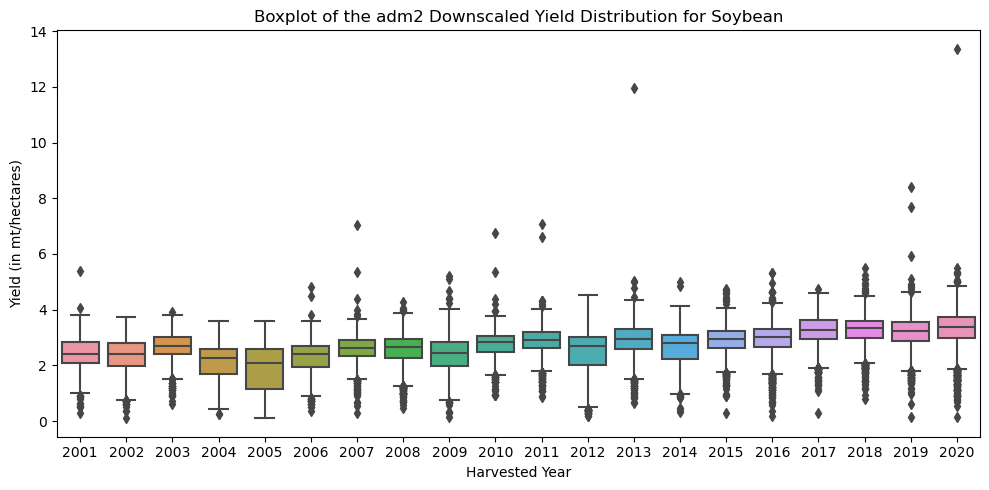

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.boxplot(data = df_dwnscl, x = 'year', y = 'downscaled_yield')
ax.set(title = 'Boxplot of the adm2 Downscaled Yield Distribution for Soybean',
       xlabel = 'Harvested Year', ylabel = 'Yield (in mt/hectares)')
plt.tight_layout()

## Filtering out outliers

The step of filtering is a critical step and it involves removing the redundant and unrealistic datasets. The reported yield over 5 mt/ha for a county is unrealistic and should be removed as a part of the filtering process.

In [ ]:
print("It was observed that there were " + str(
    len(df_dwnscl[df_dwnscl['downscaled_yield']>=5])) +
      " data points where the downscaled yield was above 5 mt/hectares.")

It was observed that there were 32 data points where the downscaled yield was above 5 mt/hectares.


In [ ]:
df_filtered_ = df_dwnscl[df_dwnscl['downscaled_yield']<5]
df_filtered_.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38411 entries, 0 to 38467
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          38411 non-null  int64  
 1   meso_iso                      38411 non-null  object 
 2   muni_iso                      38411 non-null  int64  
 3   downscaled_production         38411 non-null  float64
 4   downscaled_acreage_harvested  38411 non-null  float64
 5   downscaled_yield              38411 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.1+ MB


In [ ]:
df_filtered_.head(2)

,year,meso_iso,muni_iso,downscaled_production,downscaled_acreage_harvested,downscaled_yield
0,2001,BR.TO.01,1716604,3.04,1.6,1.9
1,2001,BR.TO.01,1703701,3.99,1.9,2.1


## Filtering out muni-isos with limited dataset

Determining the number of years of dataset which is available for each of the counties.

Question: Do we want to consider the counties which have available datasets for 10 years or over?! WHY?!

The _count dataframe will determine the number of years of dataset available for each county and then the bar plot will show the number of counties with the number of years of datasets.

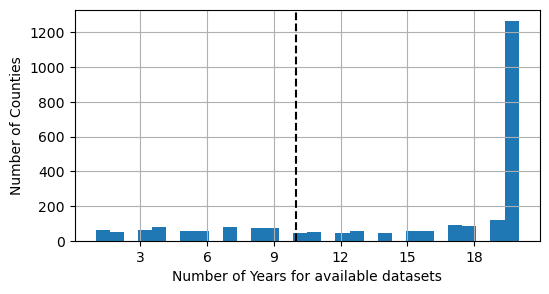

In [ ]:
_count = df_filtered_.groupby(['muni_iso']).count().reset_index()
# _count.head()
fig, ax = plt.subplots(figsize = (6, 3))
ax.hist(_count['downscaled_yield'], bins = 30)
ax.grid()
ax.set(xlabel = 'Number of Years for available datasets', ylabel = 'Number of Counties')
ax.axvline(x = 10, color = 'black', linestyle = '--')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

Number of counties for which we have over 10 years of datasets. '_count_10' is an array for all the muni_iso's with over 10 years of datasets.

In [ ]:
_count_10 = _count[_count['year'] >= 10]['muni_iso'].unique()
len(_count_10)

1918

In [ ]:
hp_filtered = df_filtered_[df_filtered_['muni_iso'].isin(_count_10)]

## Calculating the HP trend

Yield cycle and yield trend for the adm2 downscaled yield was determined during this process.

In [ ]:
county_list = hp_filtered['muni_iso'].unique()
county_list

array([1716604, 1703701, 1718204, ..., 1505031, 1505650, 1506195])

In [ ]:
hp_trend = pd.DataFrame()

for i in county_list:
    df_temp = hp_filtered[hp_filtered['muni_iso']==i]

    yield_cycle, yield_trend = hpfilter(df_temp['downscaled_yield'],lamb=500)
    df_temp['hp_yield_cycle'] = yield_cycle
    df_temp['hp_yield_trend'] = yield_trend
    df_temp['hp_length'] = len(df_temp)

    hp_trend = pd.concat([hp_trend,df_temp], axis=0)

In [ ]:
hp_trend ['hp_production'] = hp_trend[
    'hp_yield_trend'] * hp_trend['downscaled_acreage_harvested']

hp_trend ['ds_minus_hp_yield'] = hp_trend[
    'downscaled_yield'] - hp_trend['hp_yield_trend']

hp_trend.tail()

,year,meso_iso,muni_iso,downscaled_production,downscaled_acreage_harvested,downscaled_yield,hp_yield_cycle,hp_yield_trend,hp_length,hp_production,ds_minus_hp_yield
38429,2016,BR.PA.02,1506195,1.994175,1.399954,1.424457,-0.863086,2.287543,13,3.202456,-0.863086
38437,2017,BR.PA.02,1506195,0.952978,0.674630,1.412593,-0.792264,2.204857,13,1.487462,-0.792264
38445,2018,BR.PA.02,1506195,2.200464,1.523050,1.444775,-0.683567,2.128342,13,3.241570,-0.683567
38455,2019,BR.PA.02,1506195,0.990805,0.675319,1.467166,-0.590080,2.057246,13,1.389297,-0.590080
38465,2020,BR.PA.02,1506195,2.259828,0.620962,3.639238,1.649789,1.989449,13,1.235372,1.649789


## Plotting HP trend

In [ ]:
hp_national = hp_trend.copy()
hp_national = hp_national.groupby(['year'], as_index=False)[[
    'downscaled_production','downscaled_acreage_harvested','hp_production']].sum()
hp_national['hp_yield'] = hp_national[
    'hp_production']/hp_national['downscaled_acreage_harvested']

hp_national['national_grids_yield'] = hp_national[
    'downscaled_production']/hp_national['downscaled_acreage_harvested']

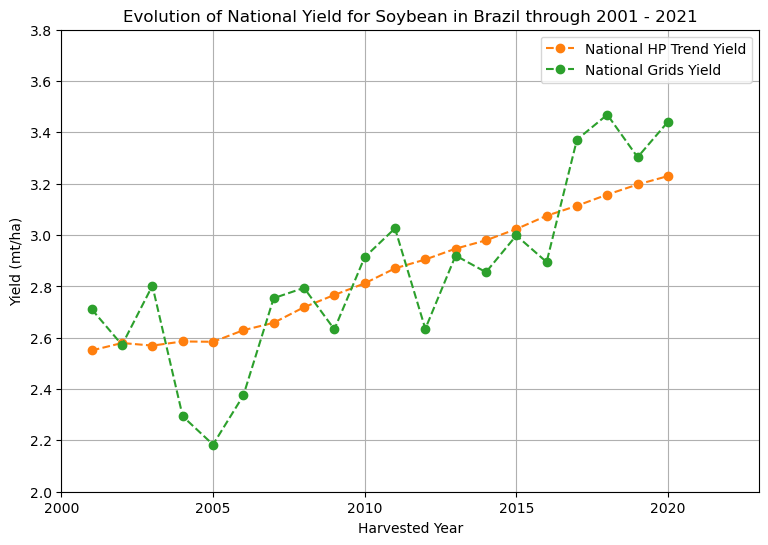

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))

plt.plot('year', 'hp_yield', data = hp_national, marker = 'o',
         linestyle = '--', label = 'National HP Trend Yield', color = 'C1')

plt.plot('year', 'national_grids_yield', data = hp_national, marker = 'o',
         linestyle = '--', label = 'National Grids Yield', color = 'C2')

ax.set(title = "Evolution of National Yield for Soybean in Brazil through 2001 - 2021",
       xlim = [2000, 2023], ylim = [2.0, 3.8],
       xlabel = 'Harvested Year', ylabel = 'Yield (mt/ha)')
plt.grid()
plt.legend()
plt.show()

## Statistics of trend deviation at national level

At this point, it is beneficial to import a function from feature selection utility at the bunge.dsci directory. The feature selection has already been imported as bfs. This function 'n_weighted_moment' from this utility gives out the weighted average, weighted standard deviation, weighted skewness, and weighted skewness from a dataframe. The inputs for the 'n_weighted_moment' function are var1 (whose descriptive stats has to be reported), var2 (around whom the weights will be determined), and n (1,2,3,4).

In [ ]:
trend_plot = hp_trend.copy()
var1 = trend_plot['ds_minus_hp_yield']
var2 = trend_plot['downscaled_acreage_harvested']

weighted_average = round(bfs.n_weighted_moment(var1, weights=var2, n=1),2)
weighted_std = round(bfs.n_weighted_moment(var1, weights=var2, n=2),2)
weighted_skew = round(bfs.n_weighted_moment(var1, weights=var2, n=3),2)
weighted_kurt = round(bfs.n_weighted_moment(var1, weights=var2, n=4),2)
n = var1.count()

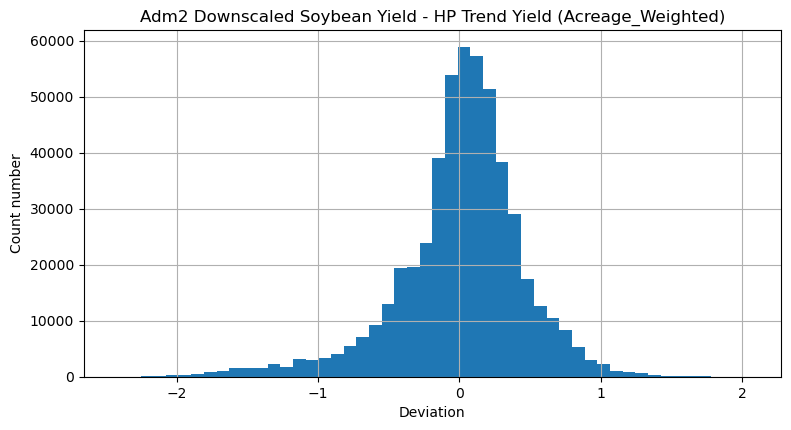

The kurtosis of the normal distribution for the yield deviation is: 5.42
The skewness of the normal distribution for the yield deviation is: -0.87
The standard deviation for the yield deviation is: 0.45
The mean for the yield deviation is: 0.01


In [ ]:
fig, ax = plt.subplots(figsize = (9, 4.5))

ax.hist(var1, bins = 50, weights = var2)

ax.grid()

ax.plot([],[], label = str(f'Weighted Kurtosis = {weighted_kurt}'), alpha=0)
ax.plot([],[], label = str(f'Weighted Skewness = {weighted_skew}'), alpha=0)
ax.plot([],[], label = str(f'Weighted Standard Deviation = {weighted_std}'), alpha=0)
ax.plot([],[], label = str(f'Weighted Average = {weighted_average}'), alpha=0)

ax.set(title = 'Adm2 Downscaled Soybean Yield - HP Trend Yield (Acreage_Weighted)',
       xlabel = 'Deviation', ylabel = 'Count number')
plt.show()

print('The kurtosis of the normal distribution for the yield deviation is: {}'.
      format(weighted_kurt))

print('The skewness of the normal distribution for the yield deviation is: {}'.
      format(weighted_skew))

print('The standard deviation for the yield deviation is: {}'.
      format(weighted_std))

print('The mean for the yield deviation is: {}'.
      format(weighted_average))

## Yield Variance for each year

The overall idea is to assess the trend for variance during each year. In order to determine variance, difference between each individual value and the mean needs to be determined. Variance is the average of squares of those differences.

In [ ]:
df_variance = hp_trend.copy()
df_variance['mean_yield'] = df_variance.groupby('year')['downscaled_yield'].transform('mean')
df_variance['dev_from_yield'] = df_variance['downscaled_yield'] - df_variance['mean_yield']
df_variance['dev_from_yield_sq'] = df_variance['dev_from_yield']**2
df_national_var = df_variance.groupby('year')['dev_from_yield_sq'].mean().reset_index()
# df_national_var.tail()

Determining the trend in national variance from 2001 - 2021.

In [ ]:
w = np.polyfit(df_national_var['year'],df_national_var['dev_from_yield_sq'],1)
s = np.poly1d(w)

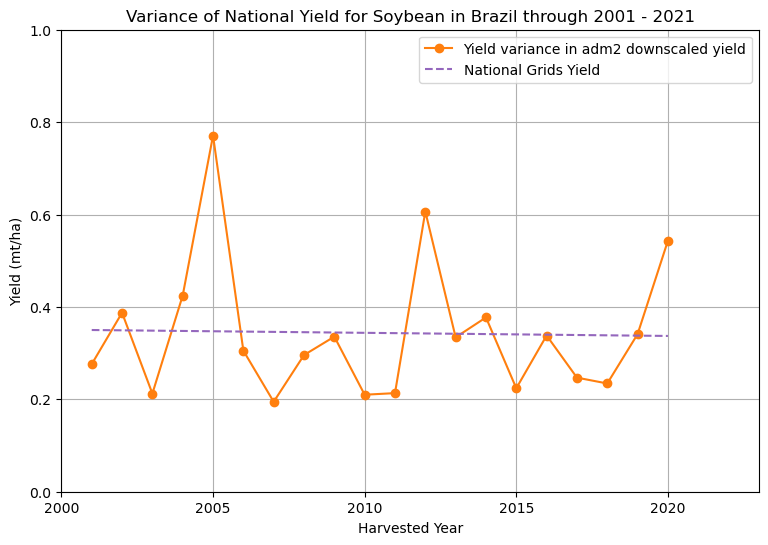

In [ ]:
fig, ax = plt.subplots(figsize = (9, 6))

plt.plot('year', 'dev_from_yield_sq', data = df_national_var, marker = 'o',
         linestyle = 'solid', label = 'Yield variance in adm2 downscaled yield', color = 'C1')

plt.plot(df_national_var['year'], s(df_national_var['year']),
         linestyle = '--', label = 'National Grids Yield', color = 'C4')

ax.set(title = "Variance of National Yield for Soybean in Brazil through 2001 - 2021",
       xlim = [2000, 2023], ylim = [0, 1],
       xlabel = 'Harvested Year', ylabel = 'Yield (mt/ha)')
plt.grid()
plt.legend()
plt.show()

## Statistics of yield deviation at adm2 level

In [ ]:
#Determining std deviation, kurtosis, and skewness for all counties from 21 years of datasets.
#Mapping these parameters on the map.